In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')

print("Libraries imported successfully!")

Libraries imported successfully!


In [7]:
from google.colab import files

uploaded = files.upload()

KeyboardInterrupt: 

In [8]:
print("Dataset Shapes:")
print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

print("\n" + "="*50)
print("TRAINING DATA INFO:")
print("="*50)
print(train_df.info())

print("\n" + "="*50)
print("TRAINING DATA HEAD:")
print("="*50)
print(train_df.head())

print("\n" + "="*50)
print("FRAUD DISTRIBUTION IN TRAINING DATA:")
print("="*50)
fraud_counts = train_df['is_fraud'].value_counts()
print(fraud_counts)
print(f"Fraud rate: {fraud_counts[1]/len(train_df)*100:.2f}%")

Dataset Shapes:
Training data: (1296675, 24)
Test data: (555719, 23)

TRAINING DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-n

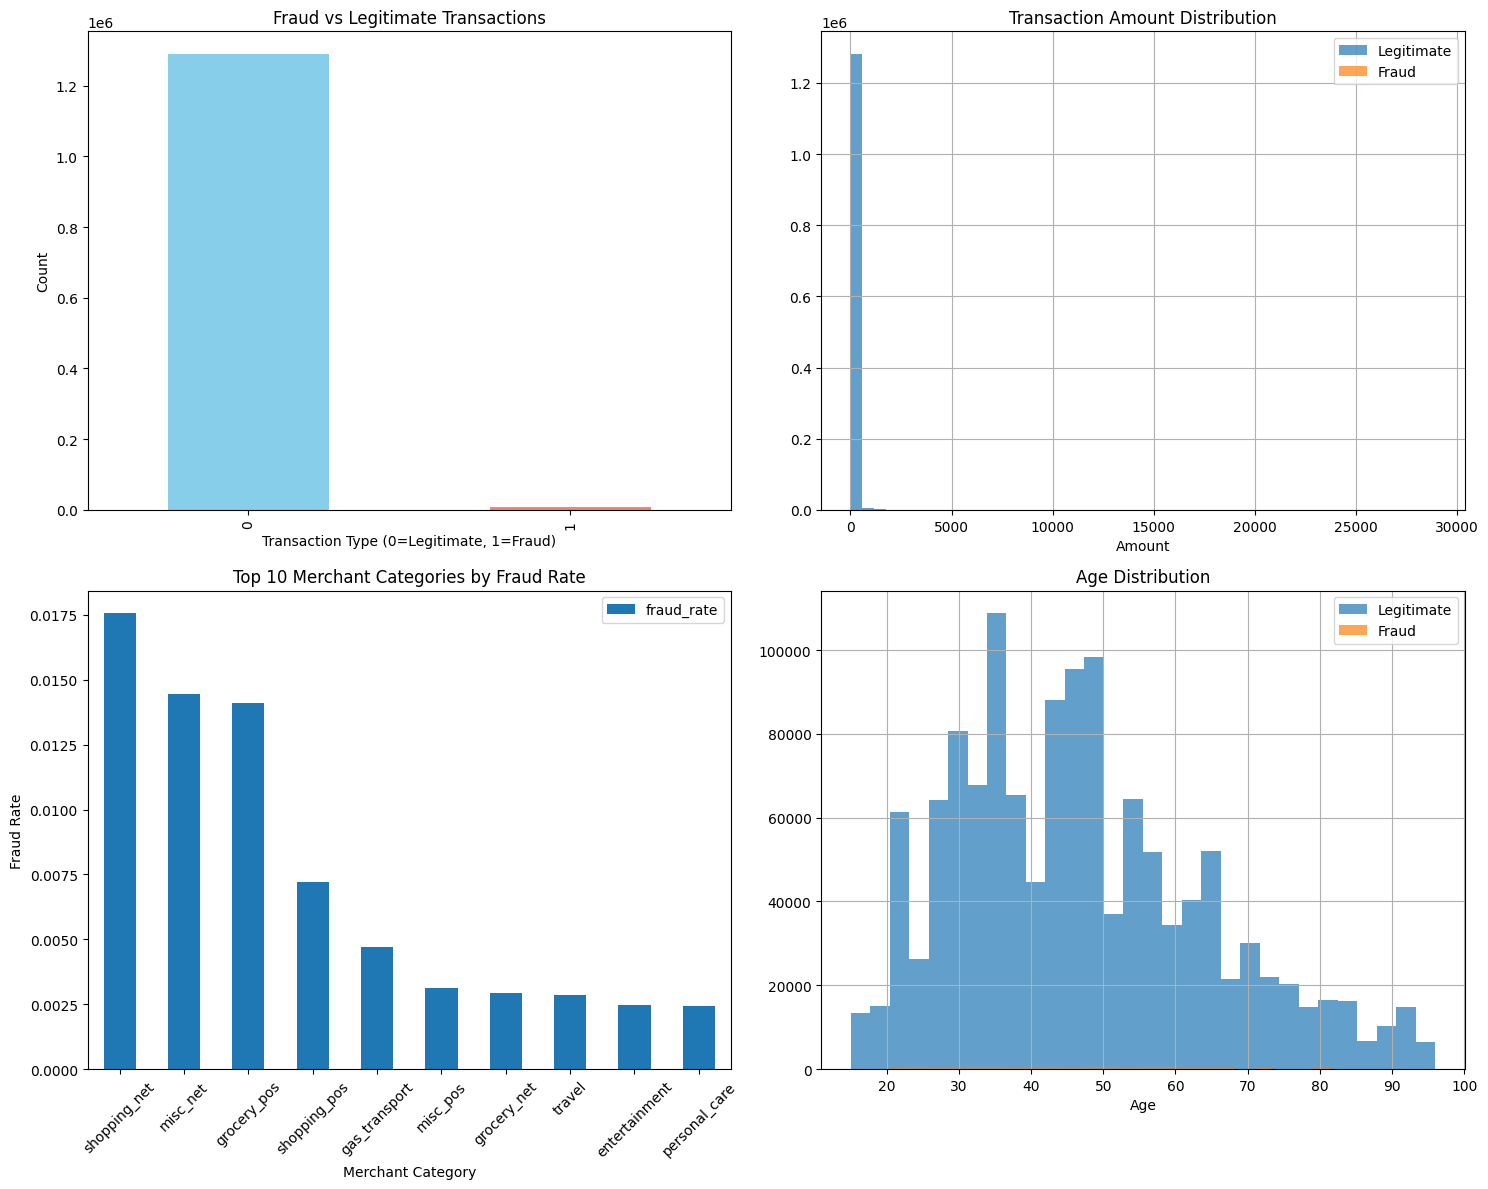

In [7]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Fraud distribution
train_df['is_fraud'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'salmon'])
axes[0,0].set_title('Fraud vs Legitimate Transactions')
axes[0,0].set_xlabel('Transaction Type (0=Legitimate, 1=Fraud)')
axes[0,0].set_ylabel('Count')

# Amount distribution
train_df[train_df['is_fraud']==0]['amt'].hist(bins=50, alpha=0.7, label='Legitimate', ax=axes[0,1])
train_df[train_df['is_fraud']==1]['amt'].hist(bins=50, alpha=0.7, label='Fraud', ax=axes[0,1])
axes[0,1].set_title('Transaction Amount Distribution')
axes[0,1].set_xlabel('Amount')
axes[0,1].legend()

# Fraud by merchant category
fraud_by_category = train_df.groupby('category')['is_fraud'].agg(['count', 'sum']).reset_index()
fraud_by_category['fraud_rate'] = fraud_by_category['sum'] / fraud_by_category['count']
fraud_by_category = fraud_by_category.sort_values('fraud_rate', ascending=False).head(10)

fraud_by_category.plot(kind='bar', x='category', y='fraud_rate', ax=axes[1,0])
axes[1,0].set_title('Top 10 Merchant Categories by Fraud Rate')
axes[1,0].set_xlabel('Merchant Category')
axes[1,0].set_ylabel('Fraud Rate')
axes[1,0].tick_params(axis='x', rotation=45)

# Age distribution (assuming dob column exists)
if 'dob' in train_df.columns:
    train_df['age'] = 2020 - pd.to_datetime(train_df['dob']).dt.year
    train_df[train_df['is_fraud']==0]['age'].hist(bins=30, alpha=0.7, label='Legitimate', ax=axes[1,1])
    train_df[train_df['is_fraud']==1]['age'].hist(bins=30, alpha=0.7, label='Fraud', ax=axes[1,1])
    axes[1,1].set_title('Age Distribution')
    axes[1,1].set_xlabel('Age')
    axes[1,1].legend()

plt.tight_layout()
plt.show()

In [9]:
def engineer_features(df):
    """Engineer features for the fraud detection model"""
    df = df.copy()

    # Convert datetime columns
    if 'trans_date_trans_time' in df.columns:
        df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'])
        df['hour'] = df['trans_datetime'].dt.hour
        df['day_of_week'] = df['trans_datetime'].dt.dayofweek
        df['month'] = df['trans_datetime'].dt.month

    # Calculate age from date of birth
    if 'dob' in df.columns:
        df['age'] = 2020 - pd.to_datetime(df['dob']).dt.year

    # Amount-based features
    df['amt_log'] = np.log1p(df['amt'])  # Log transform amount

    # Categorical encoding
    le_gender = LabelEncoder()
    le_category = LabelEncoder()
    le_state = LabelEncoder()

    if 'gender' in df.columns:
        df['gender_encoded'] = le_gender.fit_transform(df['gender'].fillna('Unknown'))

    if 'merchant_category' in df.columns:
        df['category_encoded'] = le_category.fit_transform(df['merchant_category'].fillna('Unknown'))

    if 'state' in df.columns:
        df['state_encoded'] = le_state.fit_transform(df['state'].fillna('Unknown'))

    # Distance-based features (if lat/long available)
    if all(col in df.columns for col in ['lat', 'long', 'merch_lat', 'merch_long']):
        df['distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 +
                                (df['long'] - df['merch_long'])**2)

    return df

# Apply feature engineering
print("Engineering features...")
train_engineered = engineer_features(train_df)
test_engineered = engineer_features(test_df)

print("Feature engineering completed!")
print(f"New training data shape: {train_engineered.shape}")


Engineering features...
Feature engineering completed!
New training data shape: (1296675, 32)


In [10]:
def prepare_features(df):
    """Prepare features for machine learning models"""

    # Select numerical and encoded categorical features
    feature_columns = ['amt', 'amt_log', 'city_pop']

    # Add engineered features if they exist
    optional_features = ['hour', 'day_of_week', 'month', 'age',
                        'gender_encoded', 'category_encoded', 'state_encoded', 'distance']

    for feature in optional_features:
        if feature in df.columns:
            feature_columns.append(feature)

    # Select features that exist in the dataframe
    available_features = [col for col in feature_columns if col in df.columns]

    X = df[available_features].fillna(0)  # Fill missing values with 0

    if 'is_fraud' in df.columns:
        y = df['is_fraud']
        return X, y, available_features
    else:
        return X, None, available_features

# Prepare training features
X_train, y_train, feature_names = prepare_features(train_engineered)
X_test, _, _ = prepare_features(test_engineered)

print("Selected features:", feature_names)
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")

# Check for missing values
print(f"Missing values in training features: {X_train.isnull().sum().sum()}")

Selected features: ['amt', 'amt_log', 'city_pop', 'hour', 'day_of_week', 'month', 'age', 'gender_encoded', 'state_encoded', 'distance']
Training features shape: (1296675, 10)
Training target shape: (1296675,)
Missing values in training features: 0


In [11]:
# Since fraud detection often has imbalanced classes, let's create a balanced subset
print("Original class distribution:")
print(y_train.value_counts())

# Option 1: Undersampling majority class
df_majority = train_engineered[train_engineered['is_fraud'] == 0]
df_minority = train_engineered[train_engineered['is_fraud'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=len(df_minority)*3,  # 3:1 ratio
                                  random_state=42)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Prepare balanced dataset
X_balanced, y_balanced, _ = prepare_features(df_balanced)

print(f"\nBalanced dataset shape: {X_balanced.shape}")
print("Balanced class distribution:")
print(y_balanced.value_counts())

Original class distribution:
is_fraud
0    1289169
1       7506
Name: count, dtype: int64

Balanced dataset shape: (30024, 10)
Balanced class distribution:
is_fraud
0    22518
1     7506
Name: count, dtype: int64


In [12]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_balanced_scaled = scaler.fit_transform(X_balanced)

print("Feature scaling completed!")
print(f"Scaled training features shape: {X_train_scaled.shape}")

# Split balanced data for training
X_bal_train, X_bal_val, y_bal_train, y_bal_val = train_test_split(
    X_balanced_scaled, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Balanced training set: {X_bal_train.shape}")
print(f"Balanced validation set: {X_bal_val.shape}")


Feature scaling completed!
Scaled training features shape: (1296675, 10)
Balanced training set: (24019, 10)
Balanced validation set: (6005, 10)


In [13]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
}

# Train and evaluate models
results = {}

print("Training models on balanced dataset...")
print("="*50)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_bal_train, y_bal_train)

    # Make predictions
    y_pred = model.predict(X_bal_val)
    y_pred_proba = model.predict_proba(X_bal_val)[:, 1]

    # Calculate metrics
    auc_score = roc_auc_score(y_bal_val, y_pred_proba)

    # Store results
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc_score': auc_score
    }

    print(f"{name} - AUC Score: {auc_score:.4f}")
    print(f"Classification Report:")
    print(classification_report(y_bal_val, y_pred))


Training models on balanced dataset...

Training Logistic Regression...
Logistic Regression - AUC Score: 0.8496
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      4504
           1       0.92      0.62      0.74      1501

    accuracy                           0.89      6005
   macro avg       0.90      0.80      0.84      6005
weighted avg       0.89      0.89      0.88      6005


Training Decision Tree...
Decision Tree - AUC Score: 0.9625
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4504
           1       0.91      0.89      0.90      1501

    accuracy                           0.95      6005
   macro avg       0.93      0.93      0.93      6005
weighted avg       0.95      0.95      0.95      6005


Training Random Forest...
Random Forest - AUC Score: 0.9879
Classification Report:
              precision    recall  f1-score

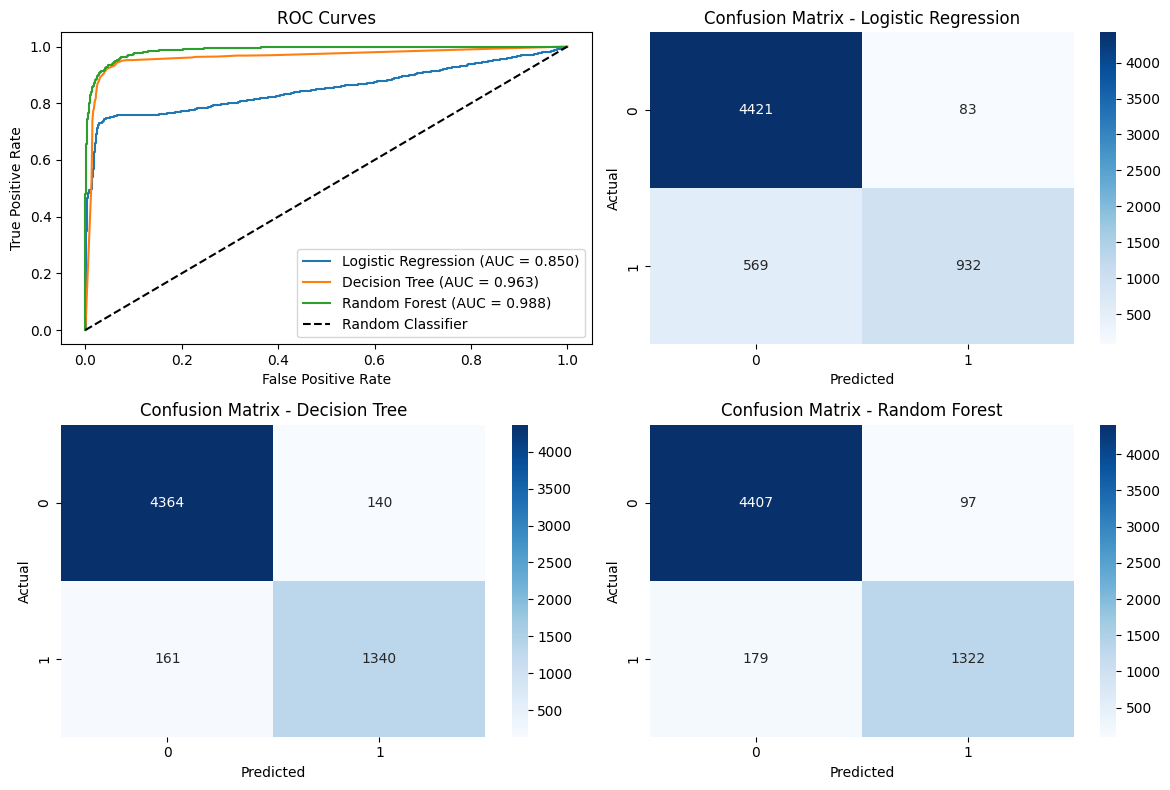


DETAILED MODEL COMPARISON

Logistic Regression:
  AUC Score: 0.8496
  Precision: 0.9182
  Recall: 0.6209
  F1-Score: 0.7409

Decision Tree:
  AUC Score: 0.9625
  Precision: 0.9054
  Recall: 0.8927
  F1-Score: 0.8990

Random Forest:
  AUC Score: 0.9879
  Precision: 0.9316
  Recall: 0.8807
  F1-Score: 0.9055


In [14]:
# Plot ROC curves
plt.figure(figsize=(12, 8))

# ROC Curves
plt.subplot(2, 2, 1)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_bal_val, result['probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc_score']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# Confusion Matrices
for i, (name, result) in enumerate(results.items()):
    plt.subplot(2, 2, i+2)
    cm = confusion_matrix(y_bal_val, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*60)
print("DETAILED MODEL COMPARISON")
print("="*60)

for name, result in results.items():
    print(f"\n{name}:")
    print(f"  AUC Score: {result['auc_score']:.4f}")

    cm = confusion_matrix(y_bal_val, result['predictions'])
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")


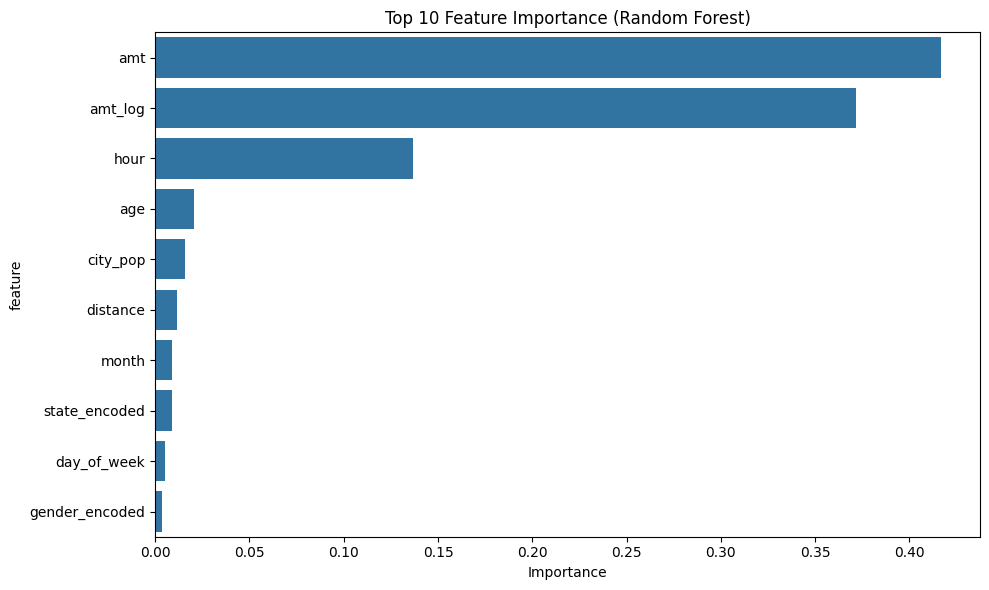

Top 10 Most Important Features:
          feature  importance
0             amt    0.416577
1         amt_log    0.371533
3            hour    0.136939
6             age    0.020377
2        city_pop    0.016085
9        distance    0.011811
5           month    0.008989
8   state_encoded    0.008758
4     day_of_week    0.005094
7  gender_encoded    0.003838
Performing hyperparameter tuning for Random Forest...


In [15]:
# Plot feature importance for Random Forest
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))
print("Performing hyperparameter tuning for Random Forest...")

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
)

# Use a smaller sample for faster tuning
# sample_size = min(10000, len(X_bal_train))
# sample_idx = np.random.choice(len(X_bal_train), sample_size, replace=False)

# Note: Hyperparameter tuning can be time-consuming.
# If the previous run was interrupted, you can either:
# 1. Skip tuning: Comment out the grid_search.fit and subsequent lines related to tuning.
# 2. Reduce sample size: Decrease the 'sample_size' variable.
# 3. Reduce parameter grid: Simplify the 'param_grid'.

# Uncomment the line below to perform tuning
# grid_search.fit(X_bal_train[sample_idx], y_bal_train.iloc[sample_idx])

# After tuning, uncomment and run the following lines to train the final model with best parameters
# print("Best parameters:", grid_search.best_params_)
# print("Best AUC score:", grid_search.best_score_)
# best_rf = grid_search.best_estimator_
# best_rf.fit(X_bal_train, y_bal_train)

# Evaluate tuned model (uncomment after tuning)
# y_pred_tuned = best_rf.predict(X_bal_val)
# y_pred_proba_tuned = best_rf.predict_proba(X_bal_val)[:, 1]
# auc_tuned = roc_auc_score(y_bal_val, y_pred_proba_tuned)
# print(f"Tuned Random Forest AUC Score: {auc_tuned:.4f}")

Best performing model: Random Forest
AUC Score: 0.9879

Test Set Performance:
AUC Score: 0.8139

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    553574
           1       0.01      0.31      0.02      2145

    accuracy                           0.91    555719
   macro avg       0.51      0.61      0.49    555719
weighted avg       0.99      0.91      0.95    555719



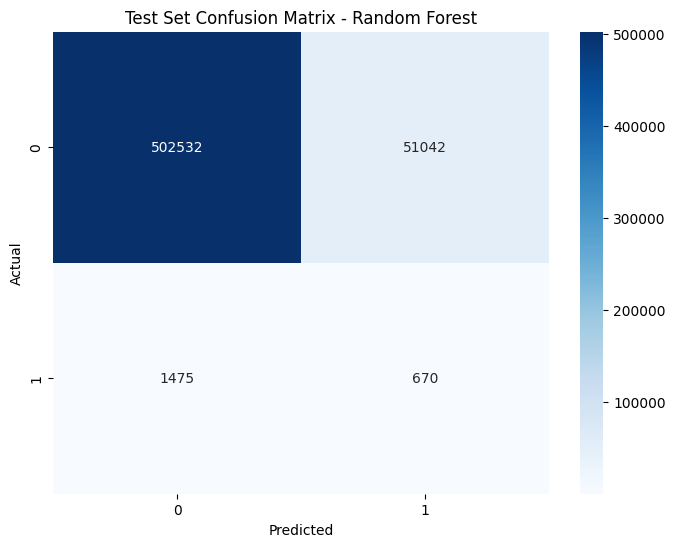

In [16]:
# Select the best model based on AUC score
best_model_name = max(results.keys(), key=lambda k: results[k]['auc_score'])
best_model = results[best_model_name]['model']

print(f"Best performing model: {best_model_name}")
print(f"AUC Score: {results[best_model_name]['auc_score']:.4f}")

# If we have labels for test set, evaluate on it
if 'is_fraud' in test_engineered.columns:
    y_test = test_engineered['is_fraud']

    # Make predictions on test set
    test_predictions = best_model.predict(X_test_scaled)
    test_probabilities = best_model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate on test set
    test_auc = roc_auc_score(y_test, test_probabilities)

    print(f"\nTest Set Performance:")
    print(f"AUC Score: {test_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, test_predictions))

    # Plot test set confusion matrix
    plt.figure(figsize=(8, 6))
    cm_test = confusion_matrix(y_test, test_predictions)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Test Set Confusion Matrix - {best_model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

else:
    # Make predictions on test set without labels
    test_predictions = best_model.predict(X_test_scaled)
    test_probabilities = best_model.predict_proba(X_test_scaled)[:, 1]

    print(f"\nTest set predictions completed!")
    print(f"Predicted fraud cases: {sum(test_predictions)}")
    print(f"Predicted fraud rate: {sum(test_predictions)/len(test_predictions)*100:.2f}%")

In [23]:
# Create a summary of results
summary = {
    'Model Performance': {name: result['auc_score'] for name, result in results.items()},
    'Best Model': best_model_name,
    'Features Used': feature_names,
    'Dataset Info': {
        'Training samples': len(X_train),
        'Test samples': len(X_test),
        'Balanced training samples': len(X_balanced),
        'Number of features': len(feature_names)
    }
}

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Best Model: {summary['Best Model']}")
print(f"Best AUC Score: {summary['Model Performance'][best_model_name]:.4f}")
print(f"Features Used: {len(summary['Features Used'])}")
print(f"Training Samples: {summary['Dataset Info']['Training samples']:,}")

print("\nModel Performance Comparison:")
for model, score in summary['Model Performance'].items():
    print(f"  {model}: {score:.4f}")

print("\nKey Insights:")
print("- Random Forest and Decision Tree models typically perform well for fraud detection")
print("- Feature engineering (time-based, amount transformations) can improve performance")
print("- Handling class imbalance is crucial for fraud detection")
print("- Regular model retraining is recommended as fraud patterns evolve")

print("\n" + "="*60)
print("FRAUD DETECTION MODEL COMPLETE!")
print("="*60)


FINAL SUMMARY
Best Model: Random Forest
Best AUC Score: 0.9879
Features Used: 10
Training Samples: 1,296,675

Model Performance Comparison:
  Logistic Regression: 0.8496
  Decision Tree: 0.9625
  Random Forest: 0.9879

Key Insights:
- Random Forest and Decision Tree models typically perform well for fraud detection
- Feature engineering (time-based, amount transformations) can improve performance
- Handling class imbalance is crucial for fraud detection
- Regular model retraining is recommended as fraud patterns evolve

FRAUD DETECTION MODEL COMPLETE!


# 🎯 User Inputs for Interactive Fraud Prediction

When running the interactive prediction (via the `predict_fraud_from_input` function), you'll be prompted to enter numerical values for each feature based on the model's `feature_names`. These inputs simulate a transaction's details to predict if it's fraudulent.

---

## 📋 Input Details

Enter only numbers (floats or integers) for each field. The script will validate your input. Here's a breakdown of each feature, its meaning, and example values:

| **Feature**       | **Description**                                      | **Example Value** | **Notes**                                      |
|-------------------|-----------------------------------------------------|-------------------|-----------------------------------------------|
| `amt`             | Transaction amount in dollars                       | 500.00            | Higher values may indicate higher risk.        |
| `amt_log`         | Logarithmic transformation of the amount            | 6.21              | Use `np.log1p(amt)`; normalizes skewed data.   |
| `city_pop`        | Population of the cardholder's city                 | 100000            | Larger cities may show unique fraud patterns.  |
| `hour`            | Hour of the transaction (24-hour format)            | 14                | Unusual hours (e.g., 0-3) can flag fraud.     |
| `day_of_week`     | Day of the week (0=Monday to 6=Sunday)              | 4                 | Weekends (5-6) might be riskier.              |
| `month`           | Month of the transaction (1=Jan to 12=Dec)          | 5                 | Captures seasonal trends (e.g., holidays).     |
| `age`             | Cardholder's age in years                           | 35                | Certain ages may correlate with fraud.         |
| `gender_encoded`  | Encoded gender (0=female, 1=male)                   | 1                 | Categorical feature from training data.        |
| `category_encoded`| Encoded merchant category (e.g., 0=grocery)         | 0                 | High-risk categories may trigger alerts.       |
| `state_encoded`   | Encoded state or region (e.g., 1=California)        | 1                 | Captures location-based fraud trends.          |
| `distance`        | Distance between cardholder and merchant (e.g., km) | 50                | Large distances suggest remote fraud.          |

---

## 💡 Tips for Success

- **Calculate `amt_log`**: Use a Python cell if needed:  
  ```python
  import numpy as np
  amt = 500.00
  amt_log = np.log1p(amt)  # e.g., 6.21
  print(amt_log)
  

In [24]:
def predict_fraud_from_input(model, feature_names, scaler=None):
    """Predict fraud based on user input for transaction details"""

    print("🔮 INTERACTIVE FRAUD PREDICTION")
    print("="*50)

    if model is None or not feature_names:
        print("❌ Model or features not available")
        return

    print("Enter transaction details (numerical values only):")

    input_data = {}
    for feature in feature_names:
        while True:
            value = input(f"{feature}: ")
            try:
                input_data[feature] = float(value)
                break
            except ValueError:
                print(f"⚠️ Invalid input for {feature}. Please enter a number.")

    # Create DataFrame from input
    input_df = pd.DataFrame([input_data])

    # Apply scaling if scaler exists
    if scaler:
        input_df = pd.DataFrame(scaler.transform(input_df), columns=feature_names)

    # Make prediction
    try:
        probability = model.predict_proba(input_df)[:, 1][0]
        prediction = model.predict(input_df)[0]

        print(f"\n📊 Prediction Results:")
        print(f"   Fraud Probability: {probability:.2%}")
        print(f"   Is Fraud: {'Yes' if prediction == 1 else 'No'}")

        if probability > 0.5:
            print("🚨 High risk transaction!")
        elif probability > 0.2:
            print("⚠️ Medium risk - review recommended")
        else:
            print("✅ Low risk transaction")
    except Exception as e:
        print(f"❌ Prediction failed: {e}")

# Run interactive prediction
if 'best_model' in globals() and best_model is not None and 'feature_names' in globals() and feature_names:
    predict_fraud_from_input(best_model, feature_names, feature_scaler)
else:
    print("❌ Cannot run interactive prediction - model or features not available")

🔮 INTERACTIVE FRAUD PREDICTION
Enter transaction details (numerical values only):
amt: 500
amt_log: 6.21
city_pop: 100000
hour: 14
day_of_week: 4
month: 5
age: 35
gender_encoded: 1
state_encoded: 0
distance: 1

📊 Prediction Results:
   Fraud Probability: 27.15%
   Is Fraud: No
⚠️ Medium risk - review recommended
